In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Import Data

In [2]:
wr_stats = pd.read_csv('./data/agg_wr_final.csv')
def_points_allowed = pd.read_csv('./data/def_fpoints.csv').rename({'defteam':'team'}, axis=1)
def_injuries = pd.read_csv('./data/inj_defense.csv')
qb_stats = pd.read_csv('./data/qb_stats.csv')

In [3]:
wr_stats = wr_stats[wr_stats['position']=='WR']

In [4]:
wr_stats[['player_id', 'player_name', 'game_id', 'week', 'receiving_fpoints', 'ESPN_projection']].head()

,player_id,player_name,game_id,week,receiving_fpoints,ESPN_projection
3,00-0026901,Mike Wallace,2018_01_ATL_PHI,1,0.000000,NaN
5,00-0027944,Julio Jones,2018_01_ATL_PHI,1,26.900001,17.703905
7,00-0029632,Mohamed Sanu,2018_01_ATL_PHI,1,5.800000,10.506730
9,00-0030460,Markus Wheaton,2018_01_ATL_PHI,1,0.000000,NaN
11,00-0031549,Nelson Agholor,2018_01_ATL_PHI,1,11.300000,12.445405


## Clean Data

1) What are our null stats?

In [5]:
# let's drop some of these high null stats
null_stats = wr_stats.isna().sum()/wr_stats.shape[0]
null_stats[null_stats>0].sort_values(ascending=False)

twitter_username            0.678179
ESPN_projection             0.636125
avg_cushion                 0.592866
avg_separation              0.592724
target_share_4              0.483654
snap_percentage_4           0.267073
draft_round                 0.264662
draft_ovr                   0.264662
draft_pick                  0.264662
receiving_drop              0.147933
receiving_rat               0.147933
receiving_int               0.147933
receiving_drop_pct          0.147933
receiving_broken_tackles    0.147933
depth_team                  0.103397
draft_year                  0.003546
age                         0.003546
birthdate                   0.003546
height                      0.003546
weight                      0.003546
college                     0.003546
target_share_1              0.000355
dtype: float64

Let's drop some of the highly null stats. We may be able to fill these using another data source later. I could see avg_separation, receiving_rat, age, height and weight making a difference

In [6]:
# dropping stats we don't want to fil. It would affect the infromation contained in the columns
wr_stats.drop(['avg_cushion', 
               'avg_separation', 
               'twitter_username', 
               'receiving_drop', 
               'receiving_broken_tackles',
               'receiving_rat',
               'receiving_int',
               'receiving_drop_pct',
               'draft_year',
               'draft_round',
               'draft_pick',
               'draft_ovr',
               'target_share_4',
               'snap_percentage_4'], axis=1, inplace = True)


Now let's fill the rest of these null values

In [7]:
# let's also fill infinities
wr_stats.replace([np.inf, -np.inf], 0, inplace=True)

# we just want to replace the team depth with the depth most often held by the player
wr_stats["depth_team"] = wr_stats.groupby(["player_id", "season"])["depth_team"].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) > 0 else x.fillna(np.nan)
)
wr_stats["target_share_1"] = wr_stats.groupby(["player_id", "season"])["target_share_1"].transform(
    lambda x: x.fillna(x.mean())
)
# the rest of these players are low on the depth chart so let's just fill with the max
wr_stats["depth_team"] = wr_stats["depth_team"].fillna(wr_stats.depth_team.max())

# for the rest of the null stats, only 18 players have this issue. Of these, none are very impactful players (from a fantasy football persepctive). We will be dropping these statlines
wr_stats.drop(wr_stats[wr_stats.college.isna()].index, inplace = True)

In [8]:
# let's check our nulls
null_stats = wr_stats.isna().sum()/wr_stats.shape[0]
null_stats[null_stats>0].sort_values(ascending=False)

ESPN_projection    0.63483
dtype: float64

In [9]:
wr_stats.shape

(14051, 51)

we're only going to keep the top-40 performances each week. 

<Axes: xlabel='receiving_fpoints', ylabel='Count'>

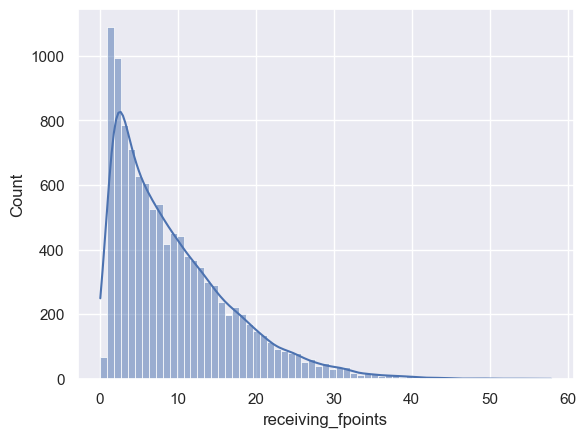

In [10]:
# should we thin out some of the lower fantasy performances?
sns.histplot(wr_stats[wr_stats['receiving_fpoints'] > 0]['receiving_fpoints'], kde=True)

In [21]:
# ADDED 6/17/2024 the last thing I want to do is just get only the top 40 performances each week, 
# first, sort by week and points
top_n = 30
roll_window = 2
wrs = wr_stats.sort_values(by = ['season', 'week', 'receiving_fpoints'], ascending = [True, True, False]).copy()
wrs = wrs.groupby(['season', 'week']).head(top_n)
wrs.shape

(3150, 51)

In [22]:
# since we are doing rolling windows, I need the previous n weeks as well
temp = pd.DataFrame(columns = wr_stats.columns)
for idx, row in wrs.iterrows():
    if row['week'] == 1:
        continue
    else:
        week = row['week']
        if week - roll_window < 1:
            final_week = 1
        else:
            final_week = week - roll_window
        for pweek in range(week-1, final_week-1, -1):
            if len(wrs[(wrs['season'] == row['season']) & \
                  (wrs['week'] == pweek) & \
                  (wrs['player_id'] == row['player_id'])]) == 0:
                   
                temp = pd.concat([temp, wr_stats[(wr_stats['season'] == row['season']) & \
                      (wr_stats['week'] == pweek) & \
                      (wr_stats['player_id'] == row['player_id'])]], 
                     ignore_index = True)
    
    # else row['week'] == 2:
    #     temp = pd.concat([temp, wr_stats[(wr_stats['season'] == row['season']) & \
    #                       (wr_stats['week'] == 1) & \
    #                       (wr_stats['player_id'] == row['player_id'])]], 
    #                      ignore_index = True)
    # else:
    #     wk = row['week']
    #     temp = pd.concat([temp, wr_stats[(wr_stats['season'] == row['season']) & \
    #                       (wr_stats['week'] == wk - 1) & \
    #                       (wr_stats['player_id'] == row['player_id'])]], 
    #                      ignore_index = True)
    #     temp = pd.concat([temp, wr_stats[(wr_stats['season'] == row['season']) & \
    #                       (wr_stats['week'] == wk - 2) & \
    #                       (wr_stats['player_id'] == row['player_id'])]], 
    #                      ignore_index = True)

wrs = pd.concat([wrs, temp], ignore_index = True).sort_values(by=['season', 'player_id', 'week']).drop_duplicates()
wrs.shape

C:\Users\cbrad\AppData\Local\Temp\ipykernel_11024\1417934023.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, wr_stats[(wr_stats['season'] == row['season']) & \


(5515, 51)

In [23]:
wrs.head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,targets_1,targets_2,targets_3,...,snap_percentage,target_share_1,target_share_2,target_share_3,target_share,air_yards_share,depth_team,wopr,opp_team,ESPN_projection
28,00-0022921,2018_01_WAS_ARI,76.0,3.000,7.0,0.0,1,7.0,2.0,1.0,...,0.981132,0.411765,0.181818,0.142857,0.277778,0.432692,1.0,0.719551,WAS,15.382099
3308,00-0022921,2018_05_ARI_SF,35.0,6.000,2.0,0.0,5,2.0,1.0,0.0,...,0.826923,0.181818,0.166667,0.000000,0.115385,0.173285,1.0,0.294377,SF,11.419710
3307,00-0022921,2018_06_ARI_MIN,39.0,2.000,5.0,0.0,6,3.0,1.0,3.0,...,0.847458,0.166667,0.142857,0.333333,0.228571,0.301435,1.0,0.553862,MIN,9.407783
203,00-0022921,2018_07_DEN_ARI,40.0,4.250,4.0,1.0,7,2.0,4.0,2.0,...,0.970588,0.105263,0.285714,0.181818,0.177778,0.124138,1.0,0.353563,DEN,10.015914
217,00-0022921,2018_08_SF_ARI,102.0,0.875,8.0,1.0,8,6.0,3.0,3.0,...,0.985507,0.333333,0.250000,0.230769,0.279070,0.506944,1.0,0.773466,SF,10.885629


<Axes: xlabel='receiving_fpoints', ylabel='Count'>

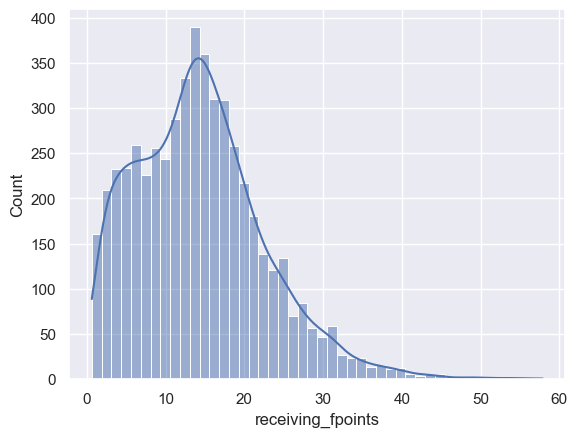

In [24]:
# this looks much better!
sns.histplot(wrs[wrs['receiving_fpoints'] > 0]['receiving_fpoints'], kde=True)

## Train, Test Split

Now that the data is clean and ready to go for ML, let's set up our testing and training data by

1. Getting windowed data so that each entry has the average of the last two weeks for features: avg yards, avg td's, etc.
2. Use SKlean to split the testing and training data

In [27]:
# now we need to get the dataset to be averages of all datapoints aside from fantasy points before the current week.
new_dataset = wrs[['player_id', 
                   'game_id', 
                   'team', 
                   'week', 
                   'season',
                   'position', 
                   'receiving_fpoints', 
                   'age', 
                   'height', 
                   'weight', 
                   'depth_team', 
                   'opp_team',
                   'ESPN_projection']]

cmas = wrs[['player_id', 'game_id', 'receiving_yards', 'avg_yac', 'receptions',
       'receiving_touchdowns', 'season', 'week', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'garbage_time_fpoints',
       'receiving_fpoints', 'avg_depth_of_target', 'air_yards',
       'max_target_depth', 'fumble_lost', 'receiving_first_downs',
       'receiving_epa', 'receiving_2pt_conversions', 'unrealized_air_yards',
       'racr', 'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'snap_percentage_1',
       'snap_percentage_2', 'snap_percentage_3', 'snap_percentage',
       'target_share_1', 'target_share_2', 'target_share_3', 'target_share',
       'air_yards_share', 'wopr']].sort_values(by=['player_id', 'season', 'week'])
cmas = cmas.set_index(['week', 'game_id']).groupby(['player_id', 'season']).rolling(roll_window, min_periods=roll_window).mean().reset_index().rename({'receiving_fpoints':'past_fpoints'}, axis=1)



In [28]:
new_dataset.shape

(5515, 13)

In [29]:
# this ensures that the new_week stat associates a players historical stats with the "current" week
# NOTE: Those with a NaN new week are players who did not play past that "week"
for idx, row in new_dataset.iterrows():
    week = row.week
    pid = row.player_id
    season = row.season

    # most recent stats
    temp_week = cmas[(cmas.season == season) & (cmas.player_id == pid) & (cmas.week < week)].week.max()
    index = cmas[(cmas.season == season) & (cmas.player_id == pid) & (cmas.week == temp_week)].index
    cmas.loc[index, 'new_week'] = week

In [30]:
print(f"The length of the dataset pre-windowing is: {len(new_dataset)}")


The length of the dataset pre-windowing is: 5515


In [31]:
new_dataset.shape

(5515, 13)

In [32]:
# now we merge cma stats
data = new_dataset.merge(cmas.drop('game_id', axis=1), 
                         left_on=['player_id', 'season', 'week'], 
                         right_on=['player_id', 'season', 'new_week'], 
                         suffixes = ('', '_remove'))
data.drop([x for x in data.columns if '_remove' in x], axis=1, inplace = True)
data.dropna(subset = cmas.columns.tolist(), inplace = True)
print(f"The length of the dataset post-windowing is: {len(data)}")
data.head()

The length of the dataset post-windowing is: 4052


,player_id,game_id,team,week,season,position,receiving_fpoints,age,height,weight,...,snap_percentage_2,snap_percentage_3,snap_percentage,target_share_1,target_share_2,target_share_3,target_share,air_yards_share,wopr,new_week
1,00-0022921,2018_06_ARI_MIN,ARI,6,2018.0,WR,8.9,39.5,75.0,218.0,...,0.891667,0.964286,0.904028,0.296791,0.174242,0.071429,0.196581,0.302989,0.506964,6.0
2,00-0022921,2018_07_DEN_ARI,ARI,7,2018.0,WR,14.0,39.5,75.0,218.0,...,0.890351,0.914286,0.837190,0.174242,0.154762,0.166667,0.171978,0.237360,0.424119,7.0
3,00-0022921,2018_08_SF_ARI,ARI,8,2018.0,WR,24.2,39.5,75.0,218.0,...,0.973684,0.950000,0.909023,0.135965,0.214286,0.257576,0.203175,0.212787,0.453713,8.0
4,00-0022921,2018_10_ARI_KC,ARI,10,2018.0,WR,11.0,39.5,75.0,218.0,...,1.000000,1.000000,0.978048,0.219298,0.267857,0.206294,0.228424,0.315541,0.563514,10.0
5,00-0022921,2018_11_OAK_ARI,ARI,11,2018.0,WR,16.3,39.5,75.0,218.0,...,0.960000,1.000000,0.965727,0.333333,0.158333,0.240385,0.253171,0.357278,0.629852,11.0


### Adding Defensive and QB Stats

In [33]:
def_points_allowed['season'] = def_points_allowed['game_id'].apply(lambda x: int(x[:4]))
qb_stats['season'] = qb_stats['game_id'].apply(lambda x: int(x[:4]))
def_injuries['season'] = def_injuries['game_id'].apply(lambda x: int(x[:4]))

In [34]:
# now we need to merge in average QBR, Average Defensive Rating, and Current Defensive Injuries
def_points_allowed.sort_values(by=['team','season','week'], inplace=True)
qb_stats.sort_values(by=['posteam', 'passer_player_id', 'season', 'week'], inplace=True)

def_points_allowed_2 = def_points_allowed.set_index(['game_id', 'week']).groupby(['team', 'season']).rolling(roll_window, min_periods=roll_window).mean().reset_index()
qb_stats_2 = qb_stats.set_index(['game_id', 'week', 'posteam']).groupby(['passer_player_id', 'season']).rolling(roll_window, min_periods=roll_window).mean().reset_index()

# I need a QB's past stats but for the current starter. 
qb_starts = qb_stats_2[['passer_player_id', 'week', 'season', 'game_id', 'posteam']].copy()

In [35]:
# because we want to correlate the average of all past performances with the current 
# def_points_allowed_2['week'] = def_points_allowed_2['week'] + 1
# qb_stats_2['week'] = qb_stats_2['week'] + 1

qbr = qb_starts.merge(qb_stats_2[['passer_player_id', 'week', 'season', 'QBR']], on=['passer_player_id', 'week', 'season'])
qbr.rename({'QBR':'hist_QBR'}, axis=1, inplace=True)
qbr.head()

,passer_player_id,week,season,game_id,posteam,hist_QBR
0,00-0019596,1,2018,2018_01_HOU_NE,NE,NaN
1,00-0019596,2,2018,2018_02_NE_JAX,NE,98.906834
2,00-0019596,3,2018,2018_03_NE_DET,NE,80.536116
3,00-0019596,4,2018,2018_04_MIA_NE,NE,77.395833
4,00-0019596,5,2018,2018_05_IND_NE,NE,98.391504


In [36]:
# let's just fill the QBR with the average for a player
qbr['hist_QBR'] = qbr.groupby(['passer_player_id', 'season'])['hist_QBR'].apply(lambda x: x.fillna(x.mean())).values
# finally, for any remaining, just fill with the league average
qbr_av = qbr['hist_QBR'].mean()
qbr['hist_QBR'] = qbr['hist_QBR'].fillna(qbr_av)
qbr.head()

,passer_player_id,week,season,game_id,posteam,hist_QBR
0,00-0019596,1,2018,2018_01_HOU_NE,NE,92.222093
1,00-0019596,2,2018,2018_02_NE_JAX,NE,98.906834
2,00-0019596,3,2018,2018_03_NE_DET,NE,80.536116
3,00-0019596,4,2018,2018_04_MIA_NE,NE,77.395833
4,00-0019596,5,2018,2018_05_IND_NE,NE,98.391504


In [37]:
# We need to only keep the starters for each week (thus, if a player got injured, we wouldn't know that ahead of time)
import nfl_data_py as nfl
dc = nfl.import_depth_charts(years=[2018, 2019, 2020, 2021, 2022, 2023])
dc.drop_duplicates(inplace=True)

starter_filter = dc[(dc['position'] == 'QB') & (dc['depth_position'] == 'QB') & (dc['depth_team'] == '1') & (dc['formation'] == 'Offense') & (dc['game_type'] == 'REG') & (dc.week > 1)].rename({'gsis_id':'passer_player_id'},axis=1)
starter_filter = starter_filter.groupby([x for x in starter_filter.columns if x != 'depth_team']).agg({'depth_team':'min'})['depth_team'].reset_index()
qbr_final = starter_filter[['passer_player_id', 'week', 'season']].merge(qbr, how='left', on = ['passer_player_id', 'week', 'season'])


In [38]:
qbr_final.dropna(subset='game_id', inplace = True)
def_points_allowed_2.dropna(subset='game_id', inplace = True)

In [39]:
# because of bye weeks we have to do this again
for idx, row in data.iterrows():
    week = row.week
    defense = row.opp_team
    offense = row.team
    season = row.season

    # most recent defensive_stats
    temp_week = def_points_allowed_2[(def_points_allowed_2.season == season) & \
                                        (def_points_allowed_2.team == defense) & \
                                        (def_points_allowed_2.week < week)].week.max()
    index = def_points_allowed_2[(def_points_allowed_2.season == season) & \
                                    (def_points_allowed_2.team == defense) & \
                                    (def_points_allowed_2.week == temp_week)].index
    def_points_allowed_2.loc[index, 'new_week'] = week

    # most recent qb stats
    temp_week = qbr_final[(qbr_final.season == season) & \
                                        (qbr_final.posteam == offense) & \
                                        (qbr_final.week < week)].week.max()
    index = qbr_final[(qbr_final.season == season) & \
                                    (qbr_final.posteam == defense) & \
                                    (qbr_final.week == temp_week)].index
    qbr_final.loc[index, 'new_week'] = week

In [40]:

data2 = data.merge(def_points_allowed_2.drop(['game_id'], axis=1), 
                    how = 'left', 
                    left_on=['opp_team', 'week', 'season'],
                    right_on=['team', 'week', 'season'], 
                    suffixes=('', '_remove'))
data2.drop([i for i in data2.columns if 'remove' in i],
               axis=1, inplace=True)
data3 = data2.merge(def_injuries.drop(['game_id'], axis=1), 
                    how = 'left', 
                    left_on=['opp_team', 'week', 'season'], 
                    right_on=['team', 'week', 'season'], 
                    suffixes=('', '_remove')) \
        .rename({'num_injured_starters': 'def_inj_starters'}, axis = 1)

# now we can get QB stats
data4 = data3.merge(qbr_final.drop(['game_id'], axis=1),
                    how = 'left', 
                    left_on=['team', 'week', 'season'], 
                    right_on=['posteam', 'week', 'season'], 
                    suffixes=('', '_remove')) \
        .drop(['passer_player_id', 'posteam'], axis = 1)

# del data, data2
# defensive stats
data4.sort_values(['season', 'week', 'team']).tail()

,player_id,game_id,team,week,season,position,receiving_fpoints,age,height,weight,...,wopr,new_week,total_qb_fpoints_given_up,total_rb_fpoints_given_up,total_wr_fpoints_given_up,total_te_fpoints_given_up,team_remove,def_inj_starters,hist_QBR,new_week_remove
3643,00-0035535,2023_18_PHI_NYG,NYG,18,2023.0,WR,17.200000,27.5,73.0,198.0,...,0.358307,18.0,20.96,34.70,43.650000,12.20,PHI,2.0,85.800827,NaN
3939,00-0038117,2023_18_PHI_NYG,NYG,18,2023.0,WR,13.500000,23.5,68.0,185.0,...,0.427080,18.0,20.96,34.70,43.650000,12.20,PHI,2.0,85.800827,NaN
3630,00-0035216,2023_18_PIT_BAL,PIT,18,2023.0,WR,18.900000,28.0,70.0,183.0,...,0.419406,18.0,10.43,33.20,23.650000,8.40,BAL,1.0,NaN,NaN
3474,00-0032211,2023_18_SEA_ARI,SEA,18,2023.0,WR,15.099999,31.7,70.0,182.0,...,0.576213,18.0,19.77,15.69,29.049999,16.55,ARI,3.0,101.001521,NaN
3388,00-0030564,2023_18_JAX_TEN,TEN,18,2023.0,WR,17.600000,32.1,73.0,212.0,...,0.443191,18.0,7.55,29.10,22.950000,3.60,NaN,NaN,NaN,NaN


In [41]:
data4.drop([x for x in data4.columns if '_remove' in x], axis=1, inplace = True)
print(f"The length of the dataset post-windowing is: {len(data4)}")
# let's drop some of these high null stats
null_stats = data4.isna().sum()/data4.shape[0]
null_stats[null_stats>0].sort_values(ascending=False)

The length of the dataset post-windowing is: 4052


def_inj_starters             0.604640
ESPN_projection              0.252962
hist_QBR                     0.098963
total_te_fpoints_given_up    0.012833
dtype: float64

In [42]:
# let's assume injured defenders is 0 when it's null
data4['def_inj_starters'] = data4['def_inj_starters'].fillna(0)

# as for the other stats, let's just fill the average
# print(f"Average QB fantasy points given up across 2023: {data4['total_qb_fpoints_given_up'].mean()}")
# data4['total_qb_fpoints_given_up'] = data4['total_qb_fpoints_given_up'].fillna(data4['total_qb_fpoints_given_up'].mean())
# print(f"Average RB fantasy points given up across 2023: {data4['total_rb_fpoints_given_up'].mean()}")
# data4['total_rb_fpoints_given_up'] = data4['total_rb_fpoints_given_up'].fillna(data4['total_rb_fpoints_given_up'].mean())
# print(f"Average WR fantasy points given up across 2023: {data4['total_wr_fpoints_given_up'].mean()}")
# data4['total_wr_fpoints_given_up'] = data4['total_wr_fpoints_given_up'].fillna(data4['total_wr_fpoints_given_up'].mean())
print(f"Average TE fantasy points given up across 2023: {data4['total_te_fpoints_given_up'].mean()}")
data4['total_te_fpoints_given_up'] = data4['total_te_fpoints_given_up'].fillna(data4['total_te_fpoints_given_up'].mean())
# finally fill QBR
print(f"Average QBR across 2018-2023: {data4['hist_QBR'].mean()}")
data4['hist_QBR'] = data4['hist_QBR'].fillna(data4['hist_QBR'].mean())

Average TE fantasy points given up across 2023: 12.14236998459231
Average QBR across 2018-2023: 90.6878449033145


### split up testing and training data

In [43]:

data4["week"] = data4.apply(lambda x: x["week"] / 18 if x["season"] >=2021 else x["week"]/17, axis=1)

data4["depth_team"] = data4["depth_team"] / 3
drop_list = ['receiving_fpoints', 
             'ESPN_projection',
             'new_week',
             'player_id', 
             'game_id', 
             'team', 
             'opp_team', 
             'position', 
             'total_te_fpoints_given_up', 
             'total_qb_fpoints_given_up', 
             'total_rb_fpoints_given_up',
             'original_index']
data4 = data4.reset_index().rename({'index':'original_index'}, axis=1)


In [44]:
rand_split = False

if rand_split:
    X_train, X_test, y_train,y_test = train_test_split(data4.drop(drop_list, axis=1), 
                                                                            data4['receiving_fpoints'], 
                                                                            test_size = 0.33, 
                                                                            random_state = 42)
else:
    train_df = data4[data4["season"] < 2023].copy()
    test_df = data4[data4["season"] == 2023].copy()

    X_train = train_df.drop(drop_list, axis=1)
    X_test = test_df.drop(drop_list, axis=1)

    y_train = train_df["receiving_fpoints"]
    y_test = test_df["receiving_fpoints"]

# scaling
non_scale_list = [
                    "week",
                    "depth_team",
                    "snap_percentage_1",
                    "snap_percentage_2",
                    "snap_percentage_3",
                    "target_share",
                    "air_yards_share",
                    "target_share_1",
                    "target_share_2",
                    "target_share_3",
                    "target_share_1",
                    "wopr",
                    "def_inj_starters"
                ]
# columns you don't need to scale:
scale_list = [
    x
    for x in data4.columns
    if x
    not in non_scale_list + drop_list
]


feature_list = scale_list + non_scale_list

# scale train data
X_train_2 = X_train[scale_list]
leftover_train = np.asarray(
            X_train[non_scale_list]
        )
y_train_s = np.asarray(y_train)

train_scaler = StandardScaler()
X_train_s = train_scaler.fit_transform(X=X_train_2)
X_train_s_all = np.concatenate((X_train_s, leftover_train), axis=1)

# scale test data
X_test_2 = X_test[scale_list]
leftover_test = np.asarray(
            X_test[non_scale_list]
        )
y_test_s = np.asarray(y_test)

test_scaler = StandardScaler()
X_test_s = test_scaler.fit_transform(X=X_test_2)
X_test_s_all = np.concatenate((X_test_s, leftover_test), axis=1)

print(f"shape1 {X_train_s.shape}, shape2: {X_train_s_all.shape}")

shape1 (3350, 33), shape2: (3350, 46)


## Let's do some machine learning

In [45]:
# let's train a simple regression model to see how we do
reg = LinearRegression()
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-5.94162466, -5.83478731, -5.65489285])

In [46]:
reg.fit(X_train_s_all, y_train_s)
y_pred_reg = reg.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(np.asarray(y_test), y_pred_reg)}")

MAE: 6.249995171093588


In [47]:
def get_test_results(test_target, preds, id_map, init_data):
    results = pd.DataFrame(test_target)
    results['yhat'] = preds
    results = results.merge(id_map, how = 'left', left_index = True, right_index = True)
    results = results.merge(init_data, how = 'left', on=['player_id', 'game_id'])
    return results


In [48]:
reg1_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
reg1_test_results.head()

,receiving_fpoints,yhat,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost,ESPN_projection
0,17.4,14.246177,00-0027944,2023_17_ARI_PHI,Julio Jones,34.0,2.0,2.0,17,0.0,NaN
1,31.5,22.291341,00-0030035,2023_03_CAR_SEA,Adam Thielen,145.0,11.0,1.0,3,0.0,9.703639
2,14.6,22.609848,00-0030035,2023_04_MIN_CAR,Adam Thielen,76.0,7.0,0.0,4,0.0,13.125377
3,27.7,18.205903,00-0030035,2023_05_CAR_DET,Adam Thielen,107.0,11.0,1.0,5,0.0,14.109426
4,28.5,14.294832,00-0030035,2023_06_CAR_MIA,Adam Thielen,115.0,11.0,1.0,6,0.0,15.753747


In [49]:
# how did ESPN do?
y_espn = np.asarray(reg1_test_results[~reg1_test_results['ESPN_projection'].isna()]['receiving_fpoints'])
yhat_espn = np.asarray(reg1_test_results[~reg1_test_results['ESPN_projection'].isna()]['ESPN_projection'])
perc_filled_espn = reg1_test_results[~reg1_test_results['ESPN_projection'].isna()].shape[0]/reg1_test_results.shape[0]
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

ESPN MAE: 6.454565271742947. ESPN projections are 83.05% of records.


In [50]:
# maybe we have a dimensionality problem. Let's just grab some predictive features
# high variance also probably means we don't have enough data
feature_idx_list = (feature_list.index('past_fpoints'), feature_list.index('receiving_first_downs'), feature_list.index('wopr'), feature_list.index('racr'))
X_train_sub = X_train_s_all[:, feature_idx_list]
cross_val_score(reg, X_train_sub, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-6.49428635, -6.39003343, -6.31944376])

In [51]:
# that's a little better
reg.fit(X_train_sub, y_train_s)
X_test_sub = X_test_s_all[:, feature_idx_list]
y_pred_reg = reg.predict(X_test_sub)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 6.412695624456389
ESPN MAE: 6.454565271742947. ESPN projections are 83.05% of records.


In [52]:
reg2_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
reg2_test_results.head()

,receiving_fpoints,yhat,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost,ESPN_projection
0,17.4,14.043309,00-0027944,2023_17_ARI_PHI,Julio Jones,34.0,2.0,2.0,17,0.0,NaN
1,31.5,14.169764,00-0030035,2023_03_CAR_SEA,Adam Thielen,145.0,11.0,1.0,3,0.0,9.703639
2,14.6,15.007222,00-0030035,2023_04_MIN_CAR,Adam Thielen,76.0,7.0,0.0,4,0.0,13.125377
3,27.7,15.773844,00-0030035,2023_05_CAR_DET,Adam Thielen,107.0,11.0,1.0,5,0.0,14.109426
4,28.5,15.964438,00-0030035,2023_06_CAR_MIA,Adam Thielen,115.0,11.0,1.0,6,0.0,15.753747


In [53]:
# we could look at random forest as well
rf = RandomForestRegressor(max_depth=4, n_jobs = -1, random_state = 42)
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-5.94162466, -5.83478731, -5.65489285])

In [54]:
rf.fit(X_train_s_all, y_train_s)

# get predictions
y_pred = rf.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 5.969713349446762
ESPN MAE: 6.454565271742947. ESPN projections are 83.05% of records.


In [55]:
rf_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
rf_test_results.head()

,receiving_fpoints,yhat,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost,ESPN_projection
0,17.4,12.542024,00-0027944,2023_17_ARI_PHI,Julio Jones,34.0,2.0,2.0,17,0.0,NaN
1,31.5,19.671997,00-0030035,2023_03_CAR_SEA,Adam Thielen,145.0,11.0,1.0,3,0.0,9.703639
2,14.6,21.239203,00-0030035,2023_04_MIN_CAR,Adam Thielen,76.0,7.0,0.0,4,0.0,13.125377
3,27.7,19.206429,00-0030035,2023_05_CAR_DET,Adam Thielen,107.0,11.0,1.0,5,0.0,14.109426
4,28.5,14.874060,00-0030035,2023_06_CAR_MIA,Adam Thielen,115.0,11.0,1.0,6,0.0,15.753747


Text(0.5, 0, 'Mean decrease in impurity')

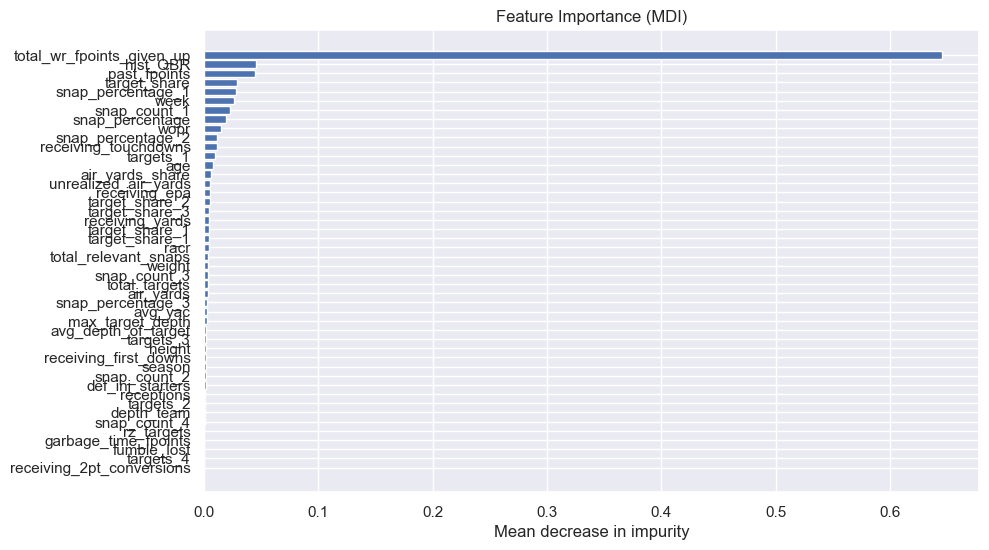

In [56]:
# obtain feature importance
feature_importance = rf.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
fig,ax = plt.subplots(figsize=(10,6))

ax.barh(pos, feature_importance[sorted_idx], align="center")

ax.set_yticks(pos, np.array(feature_list)[sorted_idx])
ax.set_title("Feature Importance (MDI)")
ax.set_xlabel("Mean decrease in impurity")

In [57]:
# finally, let's look at XGBoost
xgb = XGBRegressor(max_depth=4, n_jobs = -1, random_state = 42)
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-5.94162466, -5.83478731, -5.65489285])

In [58]:
xgb.fit(X_train_s_all, y_train_s)

# get predictions
y_pred = xgb.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 6.313690527636781
ESPN MAE: 6.454565271742947. ESPN projections are 83.05% of records.


In [59]:
xgb_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
xgb_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

,receiving_fpoints,yhat,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost,ESPN_projection
407,19.1,32.121925,00-0036358,2023_14_PHI_DAL,CeeDee Lamb,71.0,6.0,1.0,14,0.0,24.122868
164,25.1,30.507219,00-0033536,2023_03_LAC_MIN,Mike Williams,121.0,7.0,1.0,3,0.0,13.957115
80,15.7,26.873453,00-0031408,2023_15_TB_GB,Mike Evans,57.0,4.0,1.0,15,0.0,15.249223
644,1.2,26.753937,00-0038994,2023_16_DET_MIN,Jordan Addison,2.0,1.0,0.0,16,0.0,12.153097
188,25.5,26.462719,00-0033921,2023_15_TB_GB,Chris Godwin,155.0,10.0,0.0,15,0.0,12.570420


### Commentary

These models all perform very similarly. XGBoost is generally considered to be the best ML method in this genre, so we should definitely keep it as a contender. Let's check the baseline on all of these models and see where we land. From there, we can pick 2 or 3 and optimize hyperparameters to see where we can get. The hyperparameters to optimize are:

1. $n_p$ - The number of top performing players we keep in our training set.
2. $t_w$ - The number of days we take the average of for the training set (i.e. we take the average of the past two days fantasy points, recieving yards, etc.)
3. $\{f_i\}$ - The set of features we use to train the model: $f_0, f_1, f_2, ..., f_m$
4. Any model specific parameters.

### Some things we need to do:

1. Let's first grab some expert predictions in order to properly assess our model. Build out in Data Pull program DONE
2. Weather data. Build out in Data Pull program

## Baseline Model

Let's establish a baseline model that predicts last weeks performance as this weeks performace. In the 
case where there is no performance last week, the model will (for now) just grab the global average. 

In [60]:
# first let's establish a baseline model
def baseline_model(y, id_map, init_data):
    # grab results datafrmae
    results = pd.DataFrame(y)
    results = results.merge(id_map, how = 'left', left_index = True, right_index = True)
    results = results.merge(init_data.drop('receiving_fpoints',axis=1), how = 'left', on=['player_id', 'game_id'])
    
    prev_data = init_data[['player_id', 'week', 'season', 'receiving_fpoints']].copy().rename({'receiving_fpoints':'yhat'},axis=1)
    prev_data['week'] = prev_data['week'] + 1

    results = results.merge(prev_data, how='left', on=['player_id', 'week', 'season'])
    # if there was no data for the previous week, just predict the average. 
    # NOTE: This is probably bad practice since I am feeding information about the test set to the model, 
    # but there's no learning happening hear so I'm not worried about fitting issues.
    results['yhat'] = results['yhat'].fillna(init_data['receiving_fpoints'].mean())
    return results[['season',
                    'week',
                    'game_id', 
                    'player_id', 
                    'player_name',
                   'receiving_fpoints',
                    'yhat',
                    'ESPN_projection',
                    'receiving_yards', 
                     'receptions', 
                     'receiving_touchdowns',
                    'fumble_lost']]

baseline_test_results = baseline_model(y = y_test, 
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                      'season',
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection',
                                                     'receiving_fpoints']])

In [61]:
baseline_test_results.head()

,season,week,game_id,player_id,player_name,receiving_fpoints,yhat,ESPN_projection,receiving_yards,receptions,receiving_touchdowns,fumble_lost
0,2023.0,17,2023_17_ARI_PHI,00-0027944,Julio Jones,17.4,1.5,NaN,34.0,2.0,2.0,0.0
1,2023.0,3,2023_03_CAR_SEA,00-0030035,Adam Thielen,31.5,18.4,9.703639,145.0,11.0,1.0,0.0
2,2023.0,4,2023_04_MIN_CAR,00-0030035,Adam Thielen,14.6,31.5,13.125377,76.0,7.0,0.0,0.0
3,2023.0,5,2023_05_CAR_DET,00-0030035,Adam Thielen,27.7,14.6,14.109426,107.0,11.0,1.0,0.0
4,2023.0,6,2023_06_CAR_MIA,00-0030035,Adam Thielen,28.5,27.7,15.753747,115.0,11.0,1.0,0.0


In [62]:
# get predictions
print(f"MAE: {mean_absolute_error(baseline_test_results['receiving_fpoints'], baseline_test_results['yhat'])}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 8.832010705586034
ESPN MAE: 6.454565271742947. ESPN projections are 83.05% of records.


## Tuning XGBoost

Let's get the optimal XGBoost model.

In [63]:
# let's quickly see how good we can get XGBoost to predict
from xgboost import DMatrix, cv
import matplotlib.pyplot as plt

def modelfit(model, X, y, X_test, y_test, cols, useTrainCV=True, cv_folds=5, early_stopping_rounds=100, plot = False):

    cvresult = None
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = DMatrix(X, label=y)
        cvresult = cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        print(f"n_estimators: {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    evalset = [(X, y), (X_test, y_test)]
    _ = model.fit(X, y, eval_set = evalset, verbose=False)
        
    #Predict training set:
    predictions = model.predict(X)
    # dtrain_predprob = alg.predict_proba(y)[:,1]
        
    #Print model report:
    print("\nModel Report\n-------- TRAIN --------")
    print("MAE : %.4g" % mean_absolute_error(y, predictions))
    print("R2: %f" % r2_score(y, predictions))

    #Predict training set:
    predictions_test = model.predict(X_test)
    # dtrain_predprob = alg.predict_proba(y)[:,1]
    
    print("\nModel Report\n-------- TEST --------")
    print("MAE : %.4g" % mean_absolute_error(y_test, predictions_test))
    print("R2: %f" % r2_score(y_test, predictions_test))   

    if plot:
        fix, ax = plt.subplots(2,1,figsize = (10,10))
        
        feat_imp = pd.DataFrame(list(zip(cols, model.feature_importances_)), columns = ['Feature', 'Score']) \
            .sort_values(by='Score', ascending=True) \
            .set_index('Feature')
        feat_imp.plot(title='Feature Importances', ax = ax[0], kind='barh')
        ax[0].set_xlabel('Feature Importance Score')

        results = model.evals_result()
        # plot learning curves
        ax[1].plot(results['validation_0']['mean_absolute_error'], label='train')
        ax[1].plot(results['validation_1']['mean_absolute_error'], label='test')
        # show the legend
        ax[1].set_ylabel('Mean Absolute Error')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

    return model, cvresult


n_estimators: 32

Model Report
-------- TRAIN --------
MAE : 4.78
R2: 0.445858

Model Report
-------- TEST --------
MAE : 5.996
R2: 0.196976


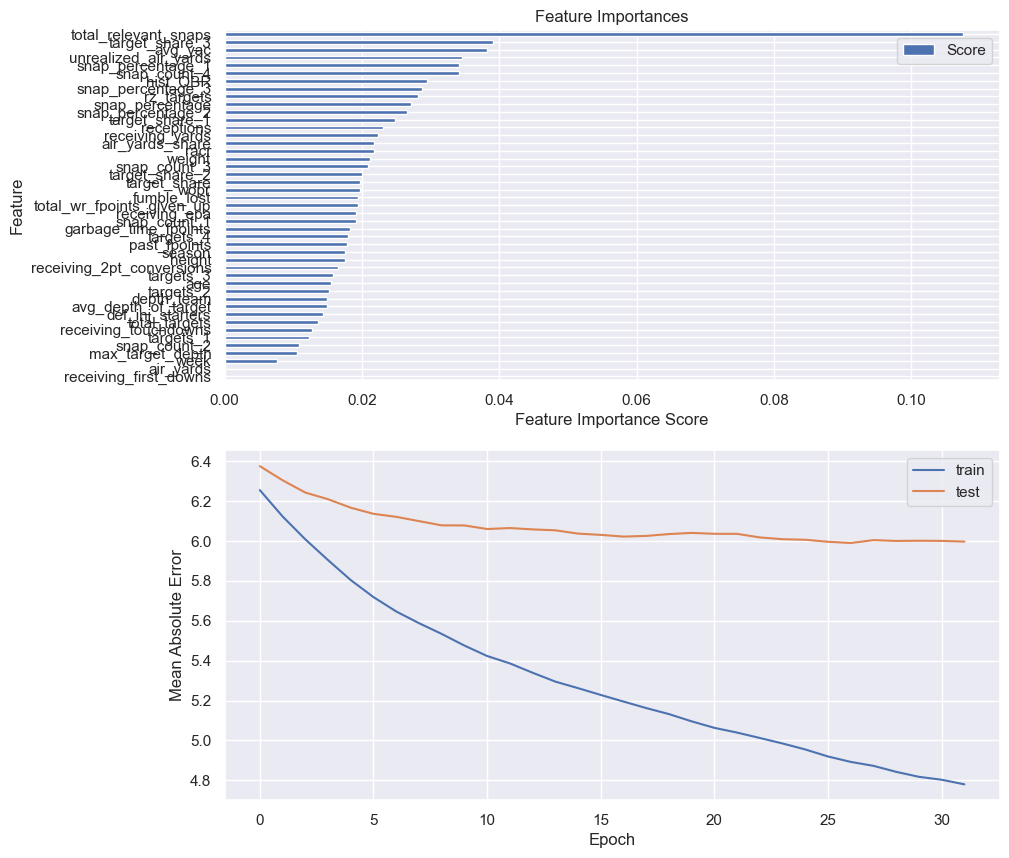

In [64]:
xgb = XGBRegressor(
    n_estimators = 1_000,
    max_depth = 5,
    max_leaves = 0,
    n_jobs = -1,
    eval_metric=mean_absolute_error,
    subsample = 0.8,
    gamma = 0,
    colsample_bytree = 0.8,
    learning_rate = 0.1,
    min_child_weight = 1
)

xgb, cv_results = modelfit(model = xgb, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [274]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb = XGBRegressor(learning_rate = 0.1, 
                     n_estimators = 33,  
                     gamma = 0, 
                     subsample = 0.8, 
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1, 
                     seed = 27)

gsearch1 = GridSearchCV(estimator = xgb,
                        param_grid = param_test1, 
                        scoring = 'neg_mean_absolute_error',
                        cv = 3)

gsearch1.fit(X_train_s_all,y_train_s)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x000001F3B98A85E0>,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interact...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=33,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='neg_mean_absolute_error')

{'max_depth': 3, 'min_child_weight': 3}
-5.512860601238251
n_estimators: 33

Model Report
-------- TRAIN --------
MAE : 5.299
R2: 0.282399

Model Report
-------- TEST --------
MAE : 5.579
R2: 0.235045


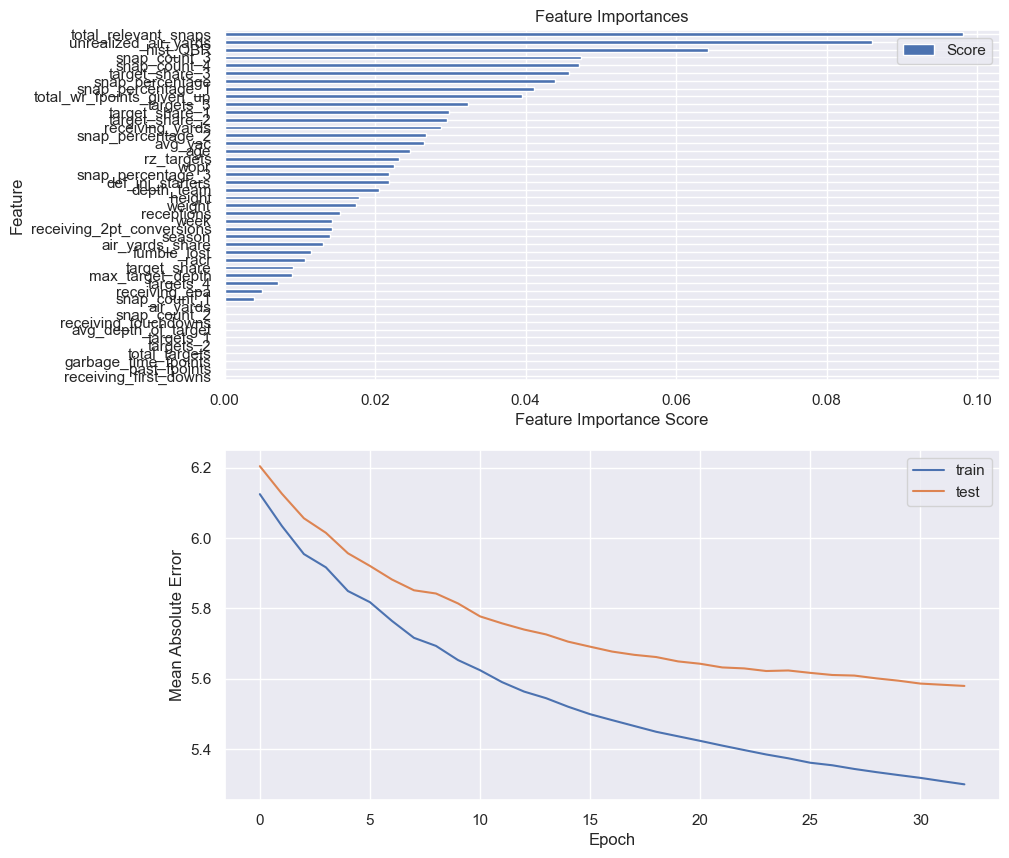

In [275]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

_, _ = modelfit(model = gsearch1.best_estimator_, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [278]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xgb = XGBRegressor(learning_rate = 0.1, 
                     n_estimators = 33, 
                     subsample = 0.8, 
                     max_depth = 3,
                     min_child_weight = 3,
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1, 
                     seed = 27)

gsearch2 = GridSearchCV(estimator = xgb,
                        param_grid = param_test2, 
                        scoring = 'neg_mean_absolute_error',
                        cv = 3)

gsearch2.fit(X_train_s_all,y_train_s)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x000001F3B98A85E0>,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=3, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=33,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='neg_mean_absolute_error')

{'gamma': 0.0}
-5.512860601238251
n_estimators: 33

Model Report
-------- TRAIN --------
MAE : 5.299
R2: 0.282399

Model Report
-------- TEST --------
MAE : 5.579
R2: 0.235045


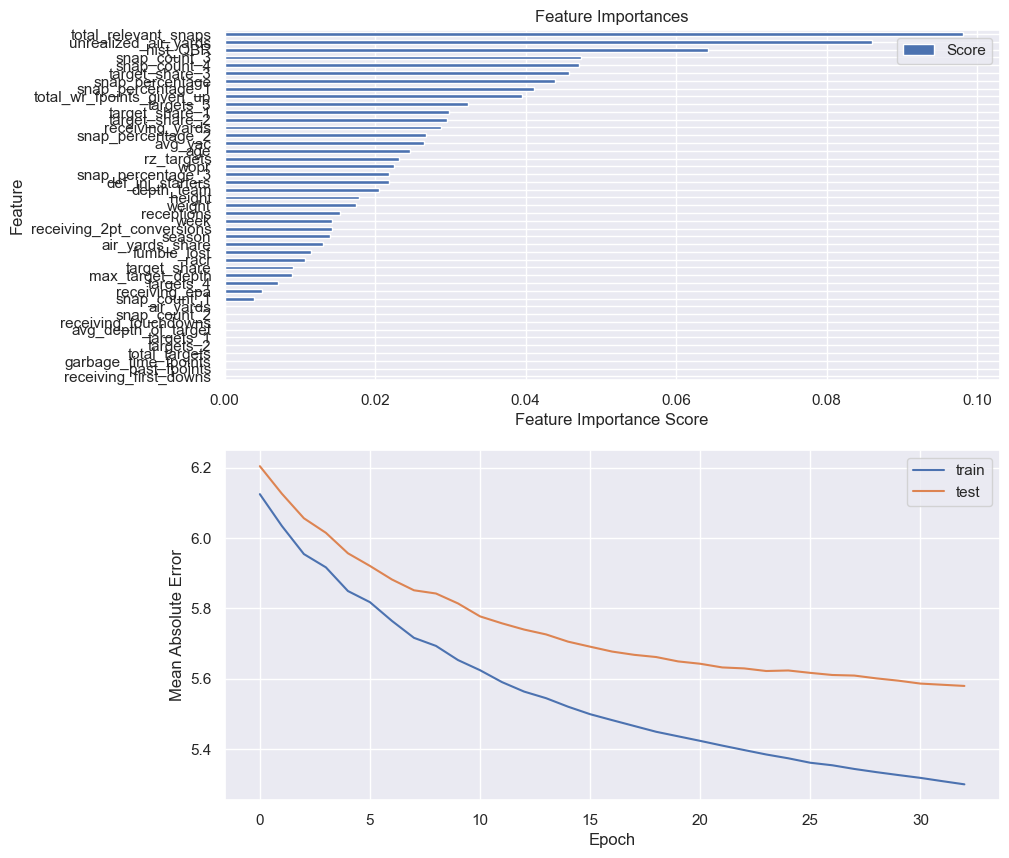

In [279]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)

_, _ = modelfit(model = gsearch2.best_estimator_, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [280]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb = XGBRegressor(learning_rate = 0.1, 
                     n_estimators = 33, 
                     subsample = 0.8, 
                     max_depth = 3,
                     gamma = 0,
                     min_child_weight = 3,
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1, 
                     seed = 27)

gsearch3 = GridSearchCV(estimator = xgb,
                        param_grid = param_test4, 
                        scoring = 'neg_mean_absolute_error',
                        cv = 3)

gsearch3.fit(X_train_s_all,y_train_s)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x000001F3B98A85E0>,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interact...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=3, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=33,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='neg_mean_absolute_error')

{'colsample_bytree': 0.8, 'subsample': 0.8}
-5.512860601238251
n_estimators: 33

Model Report
-------- TRAIN --------
MAE : 5.299
R2: 0.282399

Model Report
-------- TEST --------
MAE : 5.579
R2: 0.235045


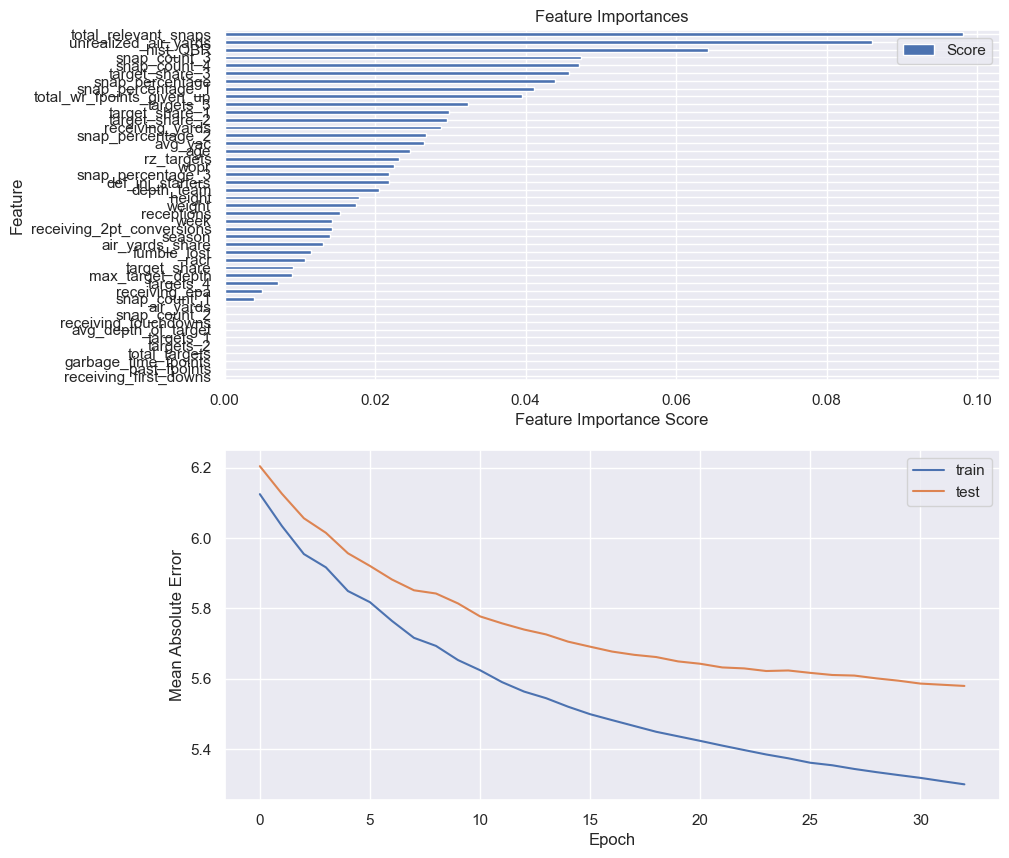

In [281]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

_, _ = modelfit(model = gsearch3.best_estimator_, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

n_estimators: 784

Model Report
-------- TRAIN --------
MAE : 5.021
R2: 0.361158

Model Report
-------- TEST --------
MAE : 5.562
R2: 0.245058


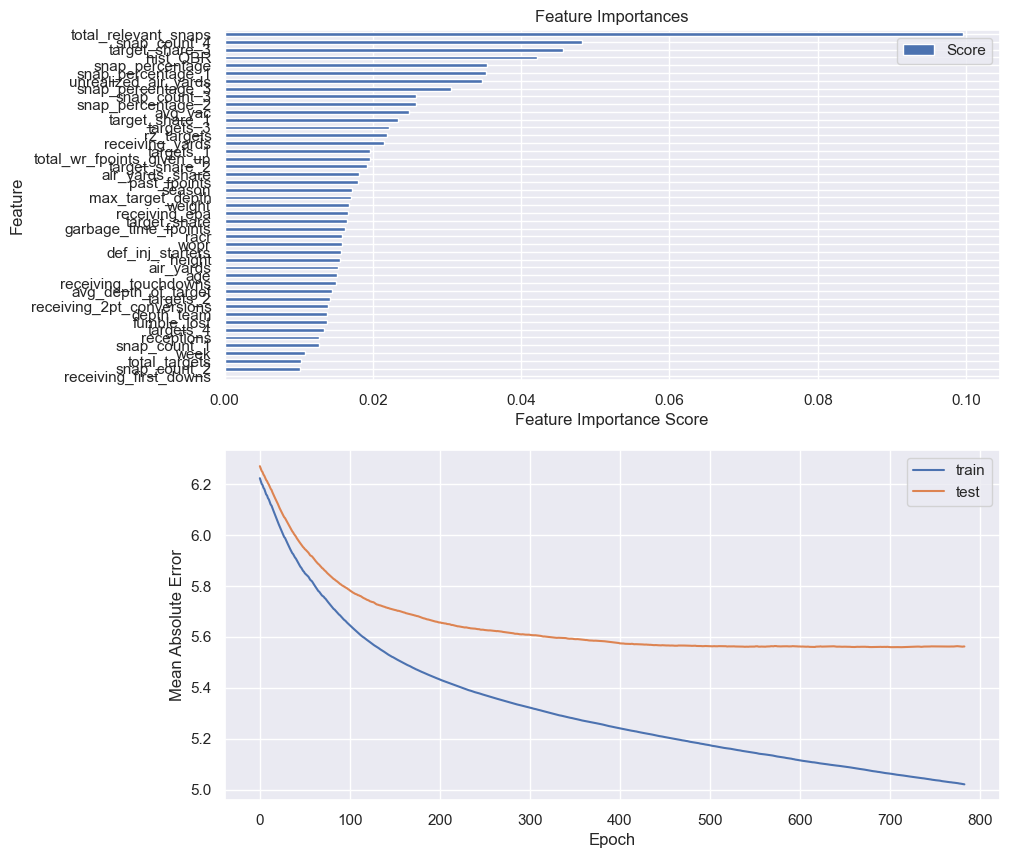

In [282]:
xgb = XGBRegressor(learning_rate = 0.01, 
                     n_estimators = 2000, 
                     subsample = 0.8, 
                     max_depth = 3,
                     gamma = 0,
                     min_child_weight = 3,
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1,
                     reg_lambda = 1,
                     seed = 27)

xgb, cv_results = modelfit(model = xgb, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [283]:
# get predictions
y_pred = xgb.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 5.562032575653834
ESPN MAE: 6.11769839039937. ESPN projections are 77.73% of records.


In [284]:
xgb_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
xgb_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

,receiving_fpoints,yhat,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost,ESPN_projection
489,32.100000,26.553587,00-0036358,2023_10_NYG_DAL,CeeDee Lamb,151.0,11.0,1.0,10,0.0,18.529302
291,49.000001,25.709074,00-0034827,2023_05_CHI_WAS,D.J. Moore,230.0,8.0,3.0,5,0.0,14.539943
15,39.500001,25.469114,00-0030279,2023_03_LAC_MIN,Keenan Allen,215.0,18.0,0.0,3,0.0,16.249075
493,19.100000,24.248112,00-0036358,2023_14_PHI_DAL,CeeDee Lamb,71.0,6.0,1.0,14,0.0,24.122868
848,6.600000,24.222448,00-0039075,2023_06_ARI_LA,Puka Nacua,26.0,4.0,0.0,6,0.0,15.510774


<Axes: xlabel='yhat', ylabel='Count'>

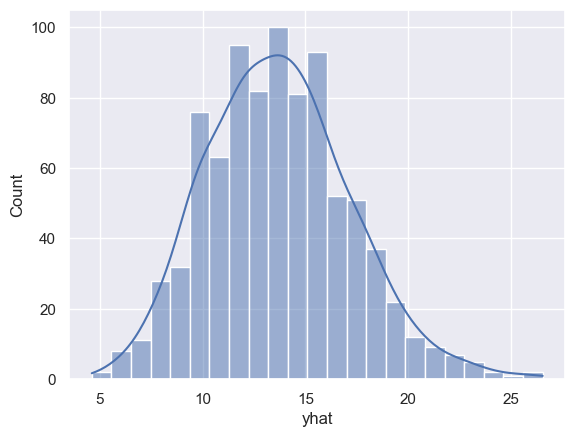

In [285]:
sns.histplot(xgb_test_results[xgb_test_results['yhat'] > 0]['yhat'], kde=True)

## Tuning Regression

That's still not better than our regression model! Let's see how well we can get regression to run.

In [286]:
# let's quickly get a baseline
reg = LinearRegression()
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-5.73744444, -5.68338667, -5.49529174])

In [287]:
# get testing scores
reg.fit(X_train_s_all, y_train_s)
y_pred_reg = reg.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.789847365146383
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


<Axes: >

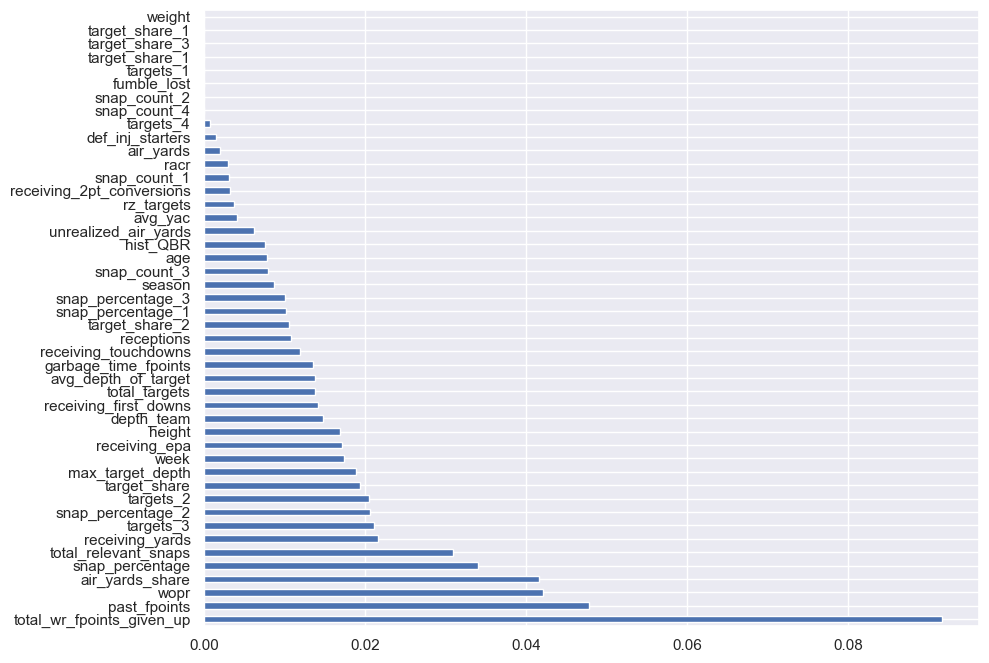

In [288]:
# let's intelligently select features
from sklearn.feature_selection import mutual_info_regression, RFE

importances = mutual_info_regression(X_train_s_all, y_train_s)
feat_importances = pd.Series(importances, feature_list).sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(10,8))
feat_importances.plot(kind='barh', ax=ax)

In [289]:
# RFE
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_train_s_all, y_train_s)
y_pred = rfe.predict(X_test_s_all)

In [290]:
# get testing scores
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.821323013719502
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [291]:
feats = []
for idx, rank in enumerate(rfe.ranking_):
    if rank == 1:
        feats.append(feature_list[idx])
        print(feature_list[idx])

feats = sorted(list(set(feats)))
feats

snap_percentage
total_wr_fpoints_given_up
depth_team
snap_percentage_2
snap_percentage_3
target_share
air_yards_share
target_share_1
target_share_1
wopr


['air_yards_share',
 'depth_team',
 'snap_percentage',
 'snap_percentage_2',
 'snap_percentage_3',
 'target_share',
 'target_share_1',
 'total_wr_fpoints_given_up',
 'wopr']

In [292]:
data4[feats]

,air_yards_share,depth_team,snap_percentage,snap_percentage_2,snap_percentage_3,target_share,target_share_1,total_wr_fpoints_given_up,wopr
0,0.302989,0.333333,0.904028,0.891667,0.964286,0.196581,0.296791,23.80,0.506964
1,0.237360,0.333333,0.837190,0.890351,0.914286,0.171978,0.174242,34.00,0.424119
2,0.212787,0.333333,0.909023,0.973684,0.950000,0.203175,0.135965,40.70,0.453713
3,0.315541,0.333333,0.978048,1.000000,1.000000,0.228424,0.219298,23.45,0.563514
4,0.357278,0.333333,0.965727,0.960000,1.000000,0.253171,0.333333,30.35,0.629852
...,...,...,...,...,...,...,...,...,...
5088,0.162994,0.333333,0.715758,0.622105,0.954545,0.194767,0.154412,47.20,0.406247
5089,0.162946,0.333333,0.599255,0.542105,0.854545,0.190789,0.196429,35.30,0.400246
5090,0.074301,0.333333,0.575428,0.480000,0.800000,0.187741,0.250000,39.95,0.333622
5091,0.134725,0.333333,0.554865,0.455000,0.792857,0.219512,0.241071,53.10,0.423576


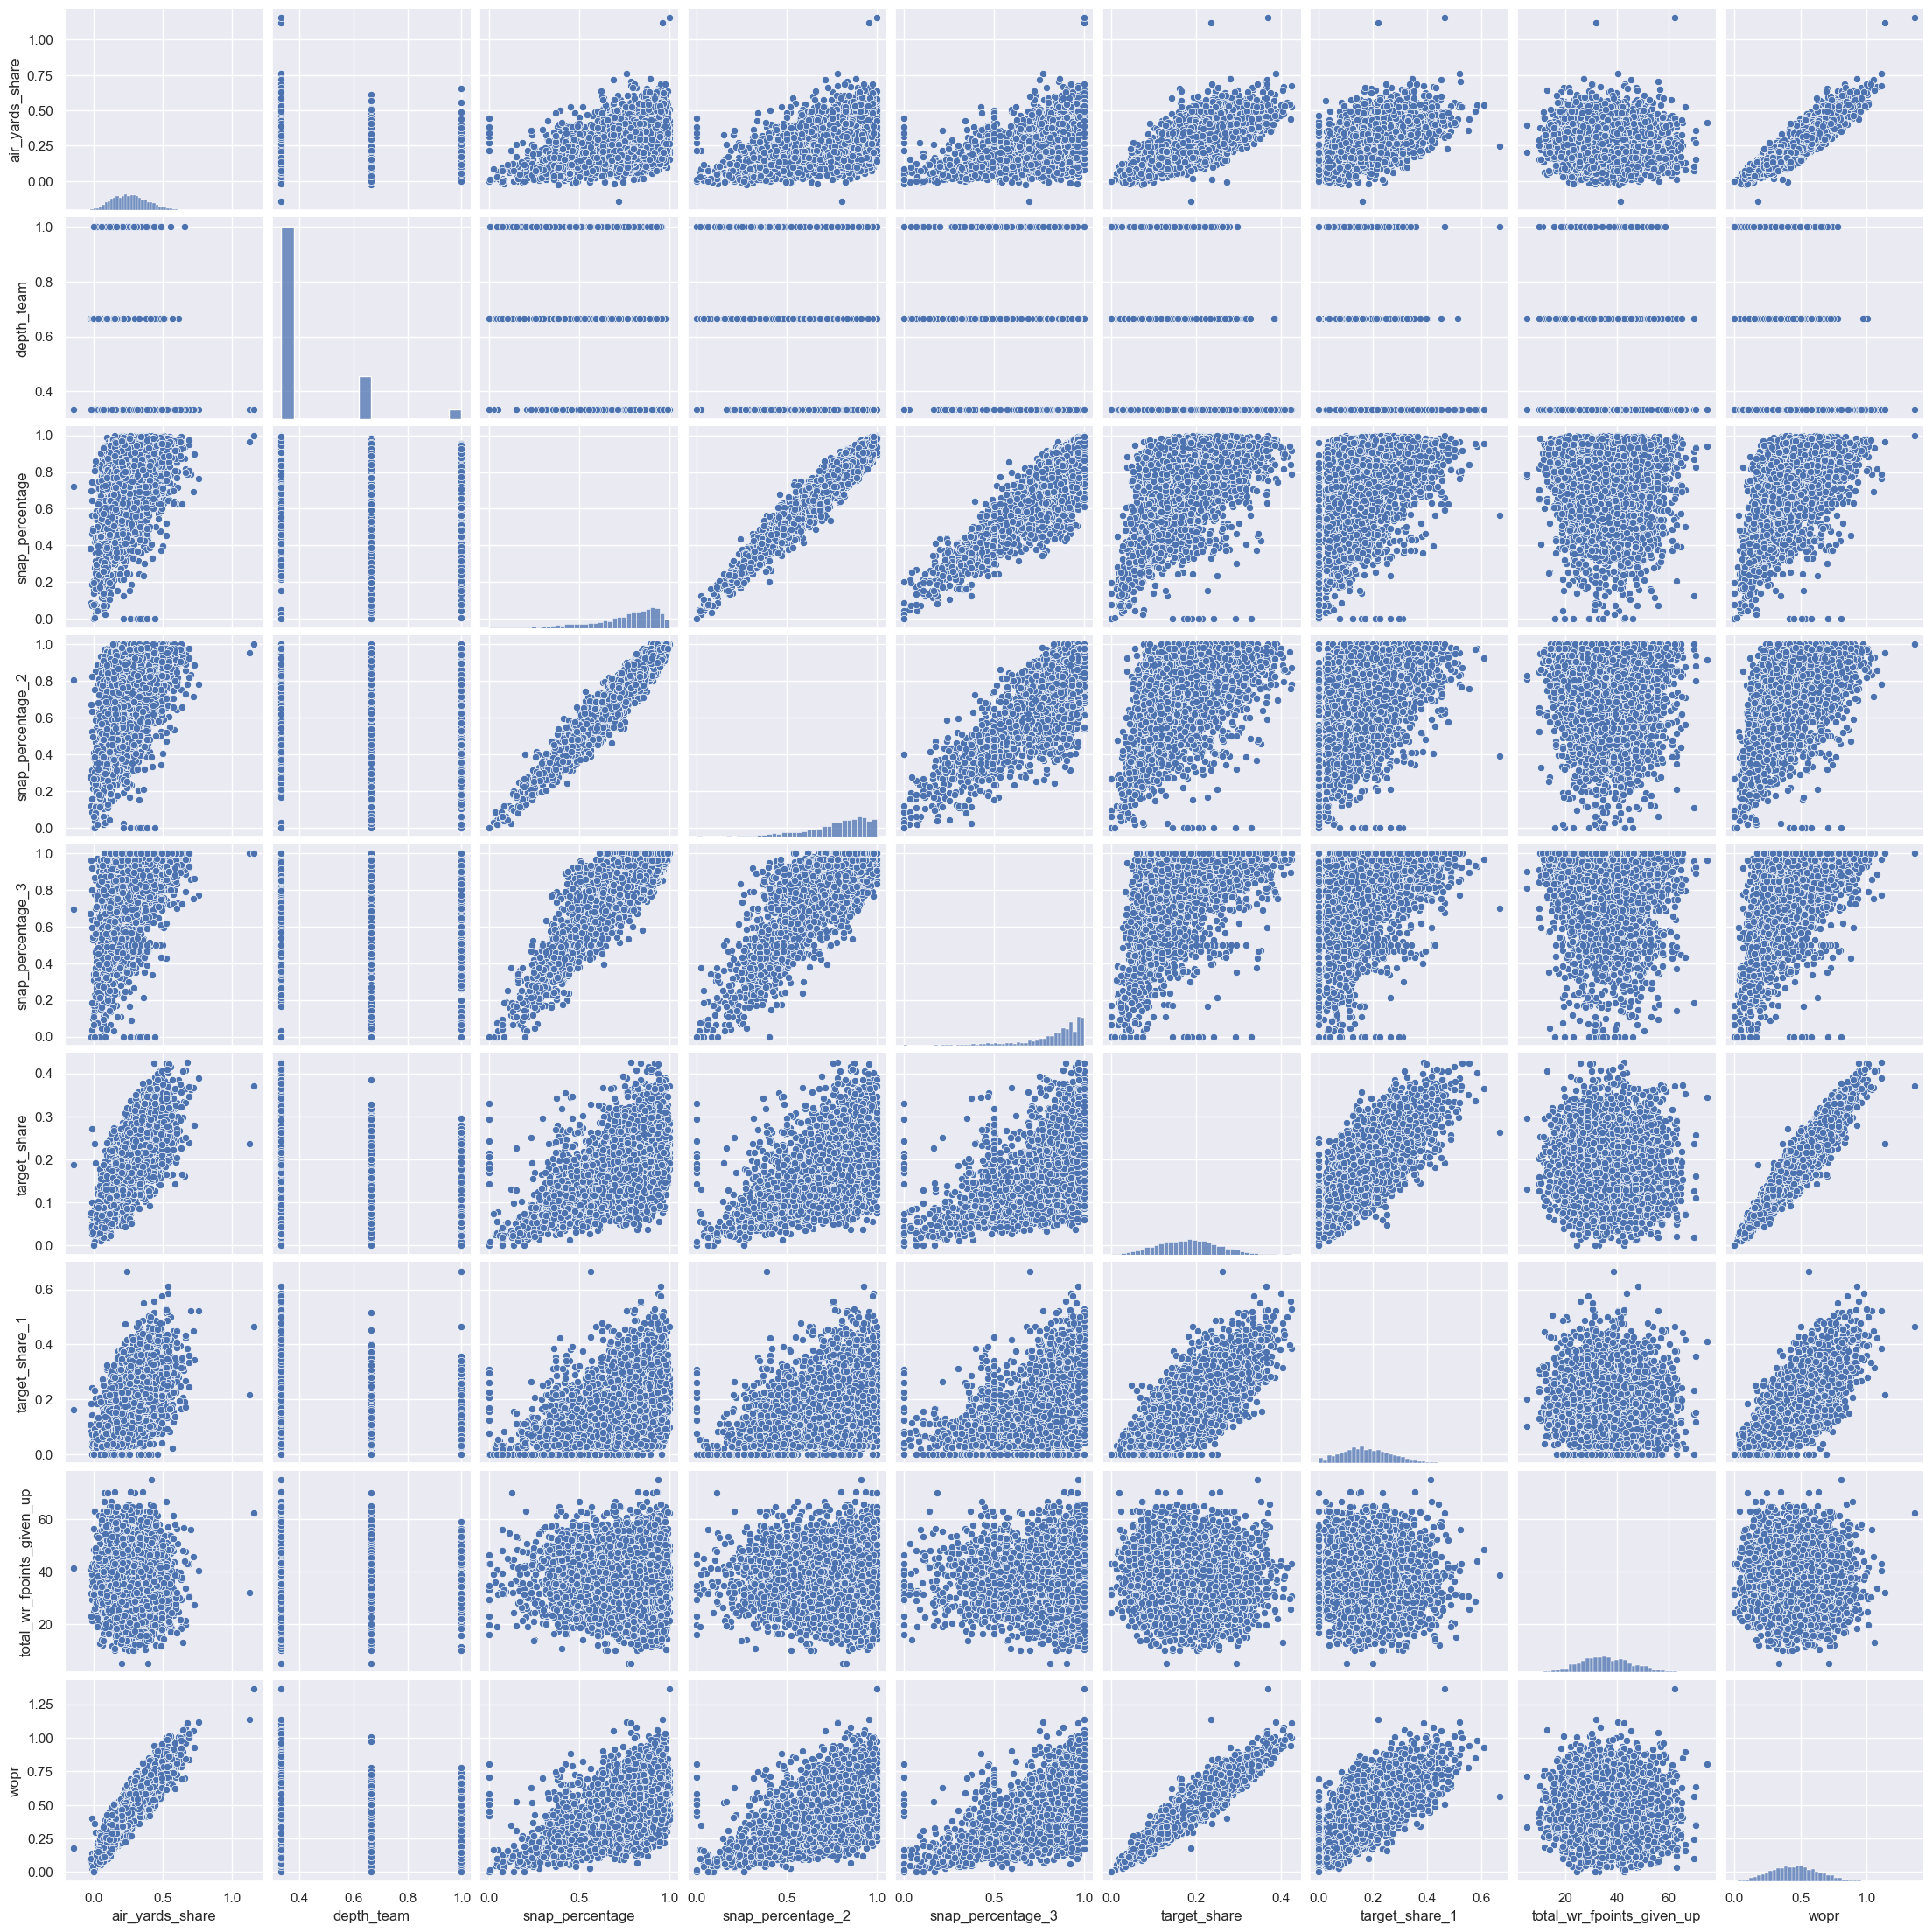

In [293]:
# let's look at the colinearity between these features
# my intuition is that the mutual_info_reg features are better
sns.pairplot(data4[feats])

In [294]:
# intuition confirmed! Snap percentage is highly coorelated with snap_percentage_1, 2 and 3.
# let's go with the first ten features from the first selection
feat_importances.head(10)

total_wr_fpoints_given_up    0.091671
past_fpoints                 0.047820
wopr                         0.042108
air_yards_share              0.041631
snap_percentage              0.034053
total_relevant_snaps         0.030933
receiving_yards              0.021601
targets_3                    0.021139
snap_percentage_2            0.020557
targets_2                    0.020502
dtype: float64

In [295]:
feature_idx_list = tuple(feature_list.index(x) for x in feat_importances.head(10).index.tolist())
X_train_sub = X_train_s_all[:, feature_idx_list]
cross_val_score(reg, X_train_sub, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-5.76058423, -5.74758105, -5.50209644])

In [296]:
# get testing scores
reg.fit(X_train_sub, y_train_s)
y_pred_reg = reg.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.8305588533800226
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [297]:
# well that's the best so far... what happens when we try polynomial features?
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train_sub)

poly2 = PolynomialFeatures(2, interaction_only = True)
X_test_poly = poly2.fit_transform(X_test_s_all[:, feature_idx_list])

In [298]:
reg.fit(X_train_poly, y_train_s)
y_pred_reg = reg.predict(X_test_poly)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.731404085099527
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [299]:
# that's not bad! 
# get testing scores
reg.fit(X_train_sub, y_train_s)
y_pred_reg = reg.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}, R2: {r2_score(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.8305588533800226, R2: 0.17879037663405906
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [300]:
#let's also try ridge
rd = Ridge()
rd.fit(X_train_sub, y_train_s)
y_pred_rd = rd.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_rd)}, R2: {r2_score(y_test_s, y_pred_rd)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.8346747896103235, R2: 0.17713997911415724
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [301]:
ls = Lasso()
ls.fit(X_train_sub, y_train_s)
y_pred_ls = ls.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_ls)}, R2: {r2_score(y_test_s, y_pred_ls)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 5.953840571803374, R2: 0.12165697052398494
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [302]:
# regular regression is fine!
# TODO: Try this again with more data.
# TODO: Add weather data
# TODO: Try a neural network.
reg_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']]) \
    [[
        'receiving_fpoints',
        'yhat',
        'ESPN_projection',
        'player_id', 
         'game_id', 
         'player_name', 
         'receiving_yards', 
         'receptions', 
         'receiving_touchdowns', 
         'week', 
         'fumble_lost'
    ]]
reg_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

,receiving_fpoints,yhat,ESPN_projection,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost
489,32.100000,24.912156,18.529302,00-0036358,2023_10_NYG_DAL,CeeDee Lamb,151.0,11.0,1.0,10,0.0
523,14.400000,23.881013,14.215540,00-0036554,2023_09_TB_HOU,Nico Collins,54.0,3.0,1.0,9,0.0
380,17.300001,23.603900,14.444615,00-0035659,2023_08_PHI_WAS,Terry McLaurin,63.0,5.0,1.0,8,0.0
383,9.300000,23.009025,13.990754,00-0035659,2023_11_NYG_WAS,Terry McLaurin,43.0,5.0,0.0,11,0.0
553,26.000000,22.978087,21.901092,00-0036900,2023_08_CIN_SF,Ja'Marr Chase,100.0,10.0,1.0,8,0.0


In [303]:
reg_test_results.sample(5)

,receiving_fpoints,yhat,ESPN_projection,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost
679,13.9,19.212758,NaN,00-0037666,2023_09_DAL_PHI,Jalen Tolbert,49.0,3.0,1.0,9,0.0
474,10.6,16.166291,NaN,00-0036345,2023_03_LAC_MIN,K.J. Osborn,36.0,1.0,1.0,3,0.0
435,2.5,14.614697,15.016267,00-0036252,2023_04_LA_IND,Michael Pittman,15.0,1.0,0.0,4,0.0
711,16.3,17.730200,8.245948,00-0037816,2023_11_LAC_GB,Romeo Doubs,53.0,5.0,1.0,11,0.0
772,20.6,11.542989,NaN,00-0038619,2023_18_CLE_CIN,Andrei Iosivas,36.0,5.0,2.0,18,0.0


In [304]:
# ok, slight improvement over ESPN data. Let's try a neural net
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.16.2


In [305]:
def build_and_compile_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

In [306]:
nn = build_and_compile_model()

In [307]:
%%time
history = nn.fit(
        X_train_s_all, 
        y_train_s,
        validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 5.52 s
Wall time: 14.7 s


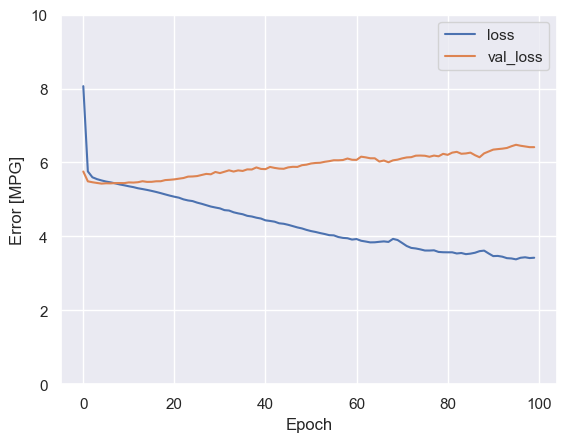

In [308]:
plot_loss(history)

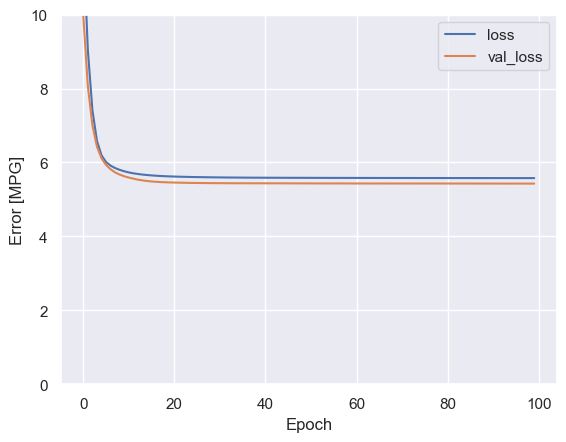

In [310]:
tf.random.set_seed(42)  #first we set random seed
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(1)
])
model.compile( loss = tf.keras.losses.mae, #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.SGD(), #stochastic GD
              metrics = ['mae'])
hist2 = model.fit( X_train_s_all, y_train_s, epochs = 100, verbose = 0, validation_split=0.2)
plot_loss(hist2)

In [311]:
y_pred_nn = model.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_nn)}, R2: {r2_score(y_test_s, y_pred_nn)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 5.774290632229858, R2: 0.1652080522272963
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [312]:
nn_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']]) \
    [[
        'receiving_fpoints',
        'yhat',
        'ESPN_projection',
        'player_id', 
         'game_id', 
         'player_name', 
         'receiving_yards', 
         'receptions', 
         'receiving_touchdowns', 
         'week', 
         'fumble_lost'
    ]].rename({'yhat':'yhat_1LD'},axis=1)
nn_test_results.sort_values(by=['yhat_1LD', 'player_id'], ascending = [False, False]).head()

,receiving_fpoints,yhat_1LD,ESPN_projection,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost
489,32.100000,24.912156,18.529302,00-0036358,2023_10_NYG_DAL,CeeDee Lamb,151.0,11.0,1.0,10,0.0
523,14.400000,23.881013,14.215540,00-0036554,2023_09_TB_HOU,Nico Collins,54.0,3.0,1.0,9,0.0
380,17.300001,23.603900,14.444615,00-0035659,2023_08_PHI_WAS,Terry McLaurin,63.0,5.0,1.0,8,0.0
383,9.300000,23.009025,13.990754,00-0035659,2023_11_NYG_WAS,Terry McLaurin,43.0,5.0,0.0,11,0.0
553,26.000000,22.978087,21.901092,00-0036900,2023_08_CIN_SF,Ja'Marr Chase,100.0,10.0,1.0,8,0.0


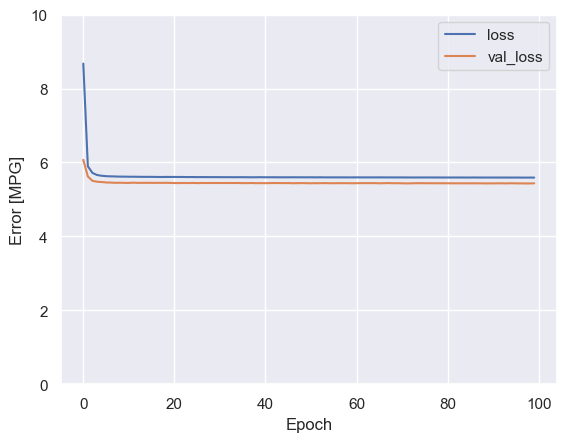

In [313]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1),
])
model2.compile( loss = tf.keras.losses.mae, #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.SGD(), #stochastic GD
              metrics = ['mae'])
hist2 = model2.fit( X_train_s_all, y_train_s, epochs = 100, verbose = 0, validation_split=0.2)
plot_loss(hist2)

In [314]:
y_pred_nn2 = model2.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_nn2)}, R2: {r2_score(y_test_s, y_pred_nn2)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 5.720684347073329, R2: 0.17022404370650412
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


In [315]:
nn_test_results["yhat_2LD"] = y_pred_nn2


In [316]:
nn_test_results[["receiving_fpoints", "yhat_1LD", "yhat_2LD", "ESPN_projection"]]

,receiving_fpoints,yhat_1LD,yhat_2LD,ESPN_projection
0,17.4,6.148046,8.671582,NaN
1,31.5,20.503135,18.279045,9.703639
2,14.6,22.424406,19.225298,13.125377
3,27.7,17.919723,15.496178,14.109426
4,28.5,14.155983,12.760052,15.753747
...,...,...,...,...
866,5.6,17.660766,17.021915,10.208909
867,10.7,13.558335,12.487507,12.169346
868,17.2,14.999464,14.156249,13.681500
869,26.9,18.939990,18.979124,11.834278


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 5.749069708975804, R2: 0.17430285002547785
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


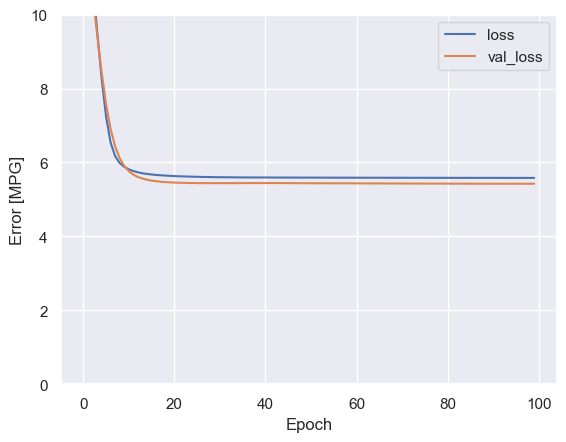

In [317]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1),
])
model3.compile( loss = tf.keras.losses.mae, #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.Adam(), #stochastic GD
              metrics = ['mae'])
hist3 = model3.fit( X_train_s_all, y_train_s, epochs = 100, verbose = 0, validation_split=0.2)
y_pred_nn3 = model3.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_nn3)}, R2: {r2_score(y_test_s, y_pred_nn3)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")
plot_loss(hist3)

In [318]:
nn_test_results["yhat_2LD_Adam"] = y_pred_nn3

In [319]:
nn_test_results[['receiving_fpoints'] + [x for x in nn_test_results.columns if 'yhat' in x] + [x for x in nn_test_results.columns if 'yhat' not in x and 'fpoints' not in x]]

,receiving_fpoints,yhat_1LD,yhat_2LD,yhat_2LD_Adam,ESPN_projection,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost
0,17.4,6.148046,8.671582,8.737579,NaN,00-0027944,2023_17_ARI_PHI,Julio Jones,34.0,2.0,2.0,17,0.0
1,31.5,20.503135,18.279045,18.424309,9.703639,00-0030035,2023_03_CAR_SEA,Adam Thielen,145.0,11.0,1.0,3,0.0
2,14.6,22.424406,19.225298,18.745316,13.125377,00-0030035,2023_04_MIN_CAR,Adam Thielen,76.0,7.0,0.0,4,0.0
3,27.7,17.919723,15.496178,15.225793,14.109426,00-0030035,2023_05_CAR_DET,Adam Thielen,107.0,11.0,1.0,5,0.0
4,28.5,14.155983,12.760052,13.278172,15.753747,00-0030035,2023_06_CAR_MIA,Adam Thielen,115.0,11.0,1.0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,5.6,17.660766,17.021915,17.526857,10.208909,00-0039146,2023_13_KC_GB,Jayden Reed,16.0,4.0,0.0,13,0.0
867,10.7,13.558335,12.487507,12.966708,12.169346,00-0039146,2023_14_GB_NYG,Jayden Reed,27.0,8.0,0.0,14,0.0
868,17.2,14.999464,14.156249,15.103219,13.681500,00-0039146,2023_15_TB_GB,Jayden Reed,52.0,6.0,1.0,15,0.0
869,26.9,18.939990,18.979124,19.893257,11.834278,00-0039146,2023_17_GB_MIN,Jayden Reed,89.0,6.0,2.0,17,0.0


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 5.71818684539346, R2: 0.18920565043928583
ESPN MAE: 6.11769839039937. 77.73% of records have ESPN projections.


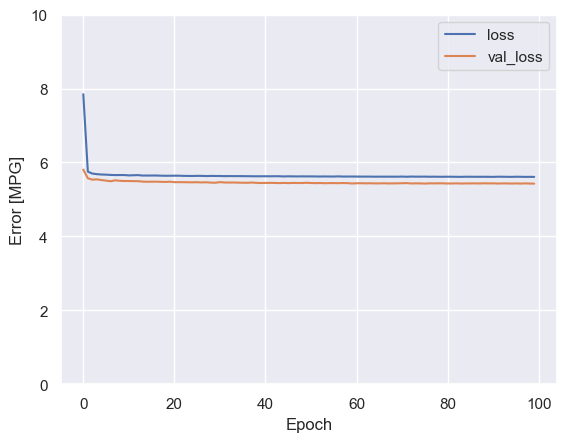

In [320]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1),
])
model4.compile( loss = tf.keras.losses.mae, #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.Adam(), #stochastic GD
              metrics = ['mae'])
hist4 = model4.fit( X_train_s_all, y_train_s, epochs = 100, verbose = 0, validation_split=0.2)
y_pred_nn4 = model4.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_nn4)}, R2: {r2_score(y_test_s, y_pred_nn4)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")
plot_loss(hist4)

In [321]:
nn_test_results["yhat_3LD_Adam"] = y_pred_nn4
nn_test_results[['receiving_fpoints'] + [x for x in nn_test_results.columns if 'yhat' in x] + [x for x in nn_test_results.columns if 'yhat' not in x and 'fpoints' not in x]]

,receiving_fpoints,yhat_1LD,yhat_2LD,yhat_2LD_Adam,yhat_3LD_Adam,ESPN_projection,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost
0,17.4,6.148046,8.671582,8.737579,8.630626,NaN,00-0027944,2023_17_ARI_PHI,Julio Jones,34.0,2.0,2.0,17,0.0
1,31.5,20.503135,18.279045,18.424309,18.186211,9.703639,00-0030035,2023_03_CAR_SEA,Adam Thielen,145.0,11.0,1.0,3,0.0
2,14.6,22.424406,19.225298,18.745316,19.670424,13.125377,00-0030035,2023_04_MIN_CAR,Adam Thielen,76.0,7.0,0.0,4,0.0
3,27.7,17.919723,15.496178,15.225793,16.162052,14.109426,00-0030035,2023_05_CAR_DET,Adam Thielen,107.0,11.0,1.0,5,0.0
4,28.5,14.155983,12.760052,13.278172,13.767073,15.753747,00-0030035,2023_06_CAR_MIA,Adam Thielen,115.0,11.0,1.0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,5.6,17.660766,17.021915,17.526857,17.588200,10.208909,00-0039146,2023_13_KC_GB,Jayden Reed,16.0,4.0,0.0,13,0.0
867,10.7,13.558335,12.487507,12.966708,12.691675,12.169346,00-0039146,2023_14_GB_NYG,Jayden Reed,27.0,8.0,0.0,14,0.0
868,17.2,14.999464,14.156249,15.103219,14.496426,13.681500,00-0039146,2023_15_TB_GB,Jayden Reed,52.0,6.0,1.0,15,0.0
869,26.9,18.939990,18.979124,19.893257,19.473017,11.834278,00-0039146,2023_17_GB_MIN,Jayden Reed,89.0,6.0,2.0,17,0.0


<img src='./Screenshot 2024-06-30 231058.png'>

In [324]:
# what would this model have predicted for my wrs for week 10?
nn_test_results[(nn_test_results["week"] == 10) & \
                (nn_test_results["player_name"].isin(["Stefon Diggs", "Brandon Aiyuk", "DeMario Douglas"]))]
# no demario, but my model did WAY better than ESPN! 

,receiving_fpoints,yhat_1LD,ESPN_projection,player_id,game_id,player_name,receiving_yards,receptions,receiving_touchdowns,week,fumble_lost,yhat_2LD,yhat_2LD_Adam,yhat_3LD_Adam
121,6.4,10.838521,20.827173,00-0031588,2023_10_DEN_BUF,Stefon Diggs,34.0,3.0,0.0,10,0.0,9.615932,9.880241,10.134478
457,14.5,14.717196,15.291962,00-0036261,2023_10_SF_JAX,Brandon Aiyuk,55.0,3.0,1.0,10,0.0,14.983471,15.609304,15.651244


In [325]:
# it really seems like the limit of this dataset is around 5.8 MAE. Most models are getting the same error
# we added data and it made the predictions worse, which meant we were overfitting the model
# The last thing to do would be to add features, and feature engineer (PCA). 
# we could also change the model paradigm and make it a time series. 

# for now I should probably focus on getting RB's TE's and QB's (DEF and K too possibly)
# clean up notebooks and pipelines, etc.